# **Road Traffic Accidents**

Fall 2024 Data Science Project

Ayat Noor, Nandini Shah, Henna Poon



**Contributions**

Ayat Noor: Drafted the introduction and formulated key research questions to establish a solid foundation for the project.
Conducted a Chi-Square test to evaluate the correlation between location (by state) and accident severity.

Henna Poon: Prepared the dataset, cleaned, and preprocessed data for analysis. Conducted initial exploratory data analysis and created visualizations for key patterns.

Nandini Shah: Explored data trends and contributed to statistical analysis. Created boxplots to highlight variations in accident severity and wrote the conclusion.

# **2. Introduction**

Traffic accidents are a significant concern worldwide, impacting public safety and economic costs. By analyzing data on road traffic accidents, we aim to uncover patterns and insights that can inform safety measures and urban planning.

# Key Questions:

How does the time of day impact the severity of road accidents?
Are weather conditions associated with the severity of road accidents?
Do certain states have significantly different accident severity distributions?

Importance: Understanding these trends is crucial for reducing traffic accidents and saving lives.

# **3. Data Curation**

The dataset for this project was sourced from Kaggle: [Road Traffic Accidents Dataset](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents). It contains data from 2017 to 2020, including details such as time, location, weather, and severity of accidents.

We used a sampled version of the dataset that contains 500,000 datapoints: [Sampled Data](https://drive.google.com/file/d/1U3u8QYzLjnEaSurtZfSAS_oh9AT2Mn8X)

Link to the paper our dataset comes from: https://dl.acm.org/doi/pdf/10.1145/3347146.3359078.

# Steps Taken to Curate the Data:

Loaded the data:
Imported the dataset into a Pandas DataFrame.

Dropped irrelevant columns:
Removed unnecessary features such as Zipcode, City, Wind Direction, and Description that did not add value to our analysis.

Simplified features:
Combined binary features like Crossing, Bump, and Railway into a single POI (Points of Interest) column.

Created new features:
Extracted Day_of_Week and Hour_of_Day from the Start_Time column for temporal analysis.

Cleaned categorical data:
Grouped weather conditions into categories such as Fair, Cloudy, Precipitation, and Low Visibility.

Filtered data: Removed rows with null or ambiguous values.

**Imports:**

In [1]:
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu
from itertools import combinations
import statsmodels.stats.multitest as multitest
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
import numpy as np

**Loading Data into Dataframe:**

In [7]:
df = pd.read_csv('US_Accidents_March23_sampled_500k.csv')

<ipython-input-7-6dc9a165a0e9>:1: DtypeWarning: Columns (29,30,31,32,33,34,35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('US_Accidents_March23_sampled_500k.csv')


**Handling Time:**

We removed End_Time and changed Start_Time to just Time.

We also added a Day_of_Week column and Hour_of_Day column to make time based comparisons easier.

In [8]:
# Rename Start_Time to Time
df.rename(columns={'Start_Time': 'Time'}, inplace=True)

# Reformat Time to be a datetime
df['Time'] = pd.to_datetime(df['Time'], format='mixed')

# Drop End_Time
df = df.drop(columns='End_Time')

# Create day and hour columns
df['Day_of_Week'] = df['Time'].dt.day_name()
df['Hour_of_Day'] = df['Time'].dt.hour

**Handling Points of Interest (POI):**

Many of the columns in our data like Bump, Crossing, and Railway indicate points of interest. We will be combining all of these columns into one called POI in order to simplify and reduce the amount of features in our dataset.

In [9]:
# Create POI column
df['POI'] = df[['Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway','Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal','Turning_Loop', 'Amenity']].any(axis=1)

# Drop all extra columns
df = df.drop(columns=['Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway','Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal','Turning_Loop', 'Amenity'])

**Drop Irrelevant Columns:**

We dropped other columns that are much too specific for our purposes including zipcode, latitude and longitude, airpoirt codes, and wind direction. We would not be able to find meaningful trends because these features might not exist for all datapoints or do not contribute in significant ways to the cause of an accident.

In [10]:
# Dropping columns that gives irrelevant location info
df = df.drop(columns=['Country', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Zipcode', 'Street', 'City', 'County', 'Distance(mi)'])

# Dropping columns that give too specific Weather info
df = df.drop(columns=['Humidity(%)', 'Weather_Timestamp', 'Wind_Direction', 'Pressure(in)', 'Wind_Speed(mph)', 'Wind_Chill(F)'])

# Dropping columns that give irrelevant time info
df = df.drop(columns=['Timezone', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'])

# Dropping columns that are unuseful
df = df.drop(columns=['Description', 'Airport_Code', 'Source'])

df

,ID,Severity,Time,State,Temperature(F),Visibility(mi),Precipitation(in),Weather_Condition,Sunrise_Sunset,Day_of_Week,Hour_of_Day,POI
0,A-2047758,2,2019-06-12 10:10:56,LA,77.0,10.00,0.00,Fair,Day,Wednesday,10,True
1,A-4694324,2,2022-12-03 23:37:14,VA,45.0,10.00,0.00,Fair,Night,Saturday,23,False
2,A-5006183,2,2022-08-20 13:13:00,CA,68.0,10.00,0.00,Fair,Day,Saturday,13,True
3,A-4237356,2,2022-02-21 17:43:04,MN,27.0,10.00,0.00,Wintry Mix,Day,Monday,17,False
4,A-6690583,2,2020-12-04 01:46:00,CA,42.0,10.00,0.00,Fair,Night,Friday,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
101041,A-933283,2,2021-08-19 06:48:01,SC,76.0,10.00,0.00,Fair,Night,Thursday,6,False
101042,A-4280589,2,2022-09-06 09:30:00,DE,71.0,0.75,0.52,Heavy Rain,Day,Tuesday,9,False
101043,A-2059844,3,2019-06-19 09:20:51,VA,73.0,10.00,0.00,Mostly Cloudy,Day,Wednesday,9,False
101044,A-708466,3,2022-02-16 06:12:23,IL,46.0,10.00,0.00,Cloudy,Night,Wednesday,6,False


# **4. Exploratory Data Analysis**

### **Analysis 1: Time of Day and Severity**


---



Preprocessing dataframe to organize a sub df for data used for examining relationship between time of day and accident severity.

In [11]:
time_df = df[['Severity', 'Sunrise_Sunset']]
time_df = time_df.dropna()

time_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100743 entries, 0 to 101044
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Severity        100743 non-null  int64 
 1   Sunrise_Sunset  100743 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


**Plot:** visualization of time of data vs severity

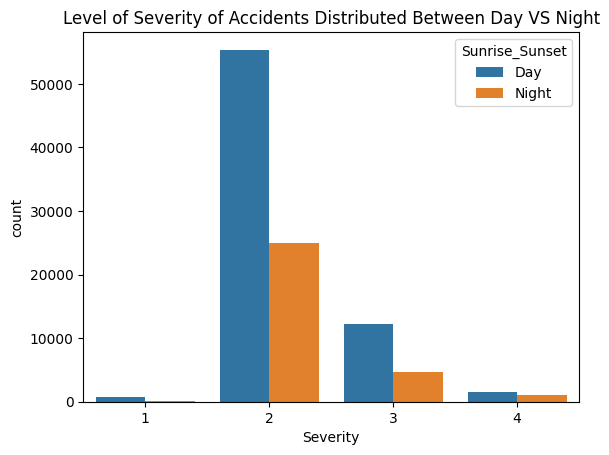

In [31]:
sns.countplot(x='Severity', hue='Sunrise_Sunset', data=time_df)
plt.title('Level of Severity of Accidents Distributed Between Day VS Night')
plt.show()

**Hypothesis Testing**: T-test

Null Hypothesis: there is no significant difference in the mean severity of accidents in the day vs night.

Alternative Hypothesis: there is a significant difference in the mean severity of accidents in the day vs the night.

In [13]:
day = time_df[time_df['Sunrise_Sunset'] == 'Day']['Severity']
night = time_df[time_df['Sunrise_Sunset'] == 'Night']['Severity']

t_stat, p_value = stats.ttest_ind(day, night)

print(p_value)
print(t_stat)

0.016270965814169723
-2.4028205472755837


**Conclusion:** Since p < alpha = 0.05, we reject the null hypothesis. This means there is a significant difference between the severity of accidents in the day vs the night.

### **Analysis 2: Weather and Severity**
---



Create sub dataframe that concerns only weather and severity.

In [14]:
# weather_df represents my dataframe with the only the values I will be working with
weather_df = df[['ID', 'Severity', 'Weather_Condition']]
weather_df = weather_df.dropna()
weather_df.head()


,ID,Severity,Weather_Condition
0,A-2047758,2,Fair
1,A-4694324,2,Fair
2,A-5006183,2,Fair
3,A-4237356,2,Wintry Mix
4,A-6690583,2,Fair




**Preprocess:** Map all precipitation, cloudy, and low visibility related weather conditions together.

In [15]:
# Precipitation Conditions
precipitation_conditions = ['rain', 'shower', 'drizzle', 'storm', 'thunder', 'mist', 'snow', 'sleet', 'hail', 'wintry', 'ice', 'precipitation']
def map_to_precipitation(condition):
    # Check if any of the keywords are in the condition (case insensitive)
    if any(keyword in condition.lower() for keyword in precipitation_conditions):
        return 'Precipitation'
    else:
        return condition
weather_df['Weather_Condition'] = weather_df['Weather_Condition'].apply(map_to_precipitation)

# Cloudy Conditions
cloudy_conditions = ['cloud', 'overcast']
def map_to_cloudy(condition):
    # Check if any of the keywords are in the condition (case insensitive)
    if any(keyword in condition.lower() for keyword in cloudy_conditions):
        return 'Cloudy'
    else:
        return condition
weather_df['Weather_Condition'] = weather_df['Weather_Condition'].apply(map_to_cloudy)

# Low Visibility Conditions
low_vis_conditions = ['fog', 'haze', 'dust', 'smoke', 'ash', 'sand','tornado', 'squalls']
def map_to_low_vis(condition):
    # Check if any of the keywords are in the condition (case insensitive)
    if any(keyword in condition.lower() for keyword in low_vis_conditions):
        return 'Low Visibility'
    else:
        return condition
weather_df['Weather_Condition'] = weather_df['Weather_Condition'].apply(map_to_low_vis)

# Fair Conditions
fair_conditions = ['fair', 'clear']
def map_to_fair(condition):
    # Check if any of the keywords are in the condition (case insensitive)
    if any(keyword in condition.lower() for keyword in fair_conditions):
        return 'Fair'
    else:
        return condition
weather_df['Weather_Condition'] = weather_df['Weather_Condition'].apply(map_to_fair)

**Hypothesis Test: Kruskal-Wallis H Test**


Null Hypothesis: The seversity of accident is the same across all weather conditions.

Alternative Hypothesis: At least one weather condition has a different distribution of severity ranks.

Alpha: 0.05

In [16]:
# Perform Kruskal-Wallis Test
kruskal_result = stats.kruskal(
    weather_df[weather_df['Weather_Condition'] == 'Fair']['Severity'],
    weather_df[weather_df['Weather_Condition'] == 'Cloudy']['Severity'],
    weather_df[weather_df['Weather_Condition'] == 'Precipitation']['Severity'],
    weather_df[weather_df['Weather_Condition'] == 'Low Visibility']['Severity']
)

print(kruskal_result)

KruskalResult(statistic=395.56608590943495, pvalue=2.0209668520030872e-85)


**Interpretation:** Since the p-value of 0.0 is less than our threshold of 0.05, that means we reject the null hypothesis, and at least one of the weather conditions does have a different distribution.

The Mann-Whitney U Test will be used as a post-hoc test to determine which weather condition had a different distribution.

In [17]:
conditions = weather_df['Weather_Condition'].unique()

# Create an empty list to store results
p_values = []

# Perform pairwise comparisons (Mann-Whitney U test)
for cond1, cond2 in combinations(conditions, 2):
    group1 = weather_df[weather_df['Weather_Condition'] == cond1]['Severity']
    group2 = weather_df[weather_df['Weather_Condition'] == cond2]['Severity']

    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

    # Store the results in a list
    p_values.append((cond1, cond2, p_value))

# Convert results into a DataFrame
pairwise_results = pd.DataFrame(p_values, columns=['Condition 1', 'Condition 2', 'p-value'])

# Apply Bonferroni correction for multiple comparisons
pairwise_results['p-adjusted'] = multitest.multipletests(pairwise_results['p-value'], method='bonferroni')[1]

# Display the results
print(pairwise_results)

     Condition 1     Condition 2       p-value    p-adjusted
0           Fair   Precipitation  4.210090e-36  2.526054e-35
1           Fair          Cloudy  1.435188e-75  8.611125e-75
2           Fair  Low Visibility  8.826114e-01  1.000000e+00
3  Precipitation          Cloudy  5.058679e-01  1.000000e+00
4  Precipitation  Low Visibility  4.622715e-09  2.773629e-08
5         Cloudy  Low Visibility  3.279177e-09  1.967506e-08


**Conclusion:** The relationship between Fair/Low Visibility and Precipitation/Cloudy don't have different distributions because their p-values are 0.2 and 0.15 respectively, which are both > 0.05. However, every other pair is under our threshold, meaning they reject the null hypothesis and have different severity distributions from each other.

**Plot:** Scattorplot will be used to get a visualisation of distributions.

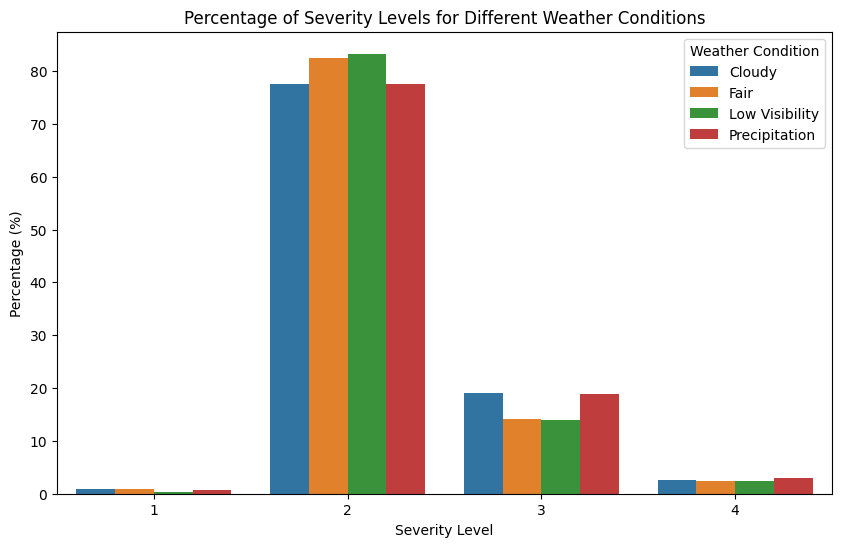

In [32]:
# Filter the dataframe for the relevant weather conditions
conditions = ['Cloudy', 'Precipitation', 'Fair', 'Low Visibility']
filtered_data = weather_df[weather_df['Weather_Condition'].isin(conditions)]

# Count occurrences of each severity level for each weather condition
counts = filtered_data.groupby(['Weather_Condition', 'Severity']).size().unstack(fill_value=0)

# Calculate percentages
percentage_counts = counts.div(counts.sum(axis=1), axis=0) * 100

# Reset the index to long format for seaborn
percentage_data = percentage_counts.reset_index().melt(id_vars='Weather_Condition', var_name='Severity', value_name='Percentage')

# Create a bar plot for percentages
plt.figure(figsize=(10, 6))
sns.barplot(x='Severity', y='Percentage', hue='Weather_Condition', data=percentage_data)

# Add labels and title
plt.xlabel('Severity Level')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Severity Levels for Different Weather Conditions')

# Show the plot
plt.legend(title='Weather Condition')
plt.show()

### **Analysis 3: Location (By State) and Severity**


---

**Hypothesis Test:** Chi-Squared Test

Null Hypothesis (H₀): There is no association between the state where an accident occurs and the severity of the accident. The two variables are independent.

Alternative Hypothesis (H₁): There is a significant association between the state and the severity of the accident. The two variables are not independent.

In [19]:
import pandas as pd
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

contingency_table = pd.crosstab(df['State'], df['Severity'])

# Perform the Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print a concise interpretation
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")

if p < 0.05:
    print("Reject the null hypothesis – There is a significant association between state and severity of accidents.")
else:
    print("Fail to reject the null hypothesis – No significant association between state and severity of accidents.")

Chi-Square Statistic: 6436.232099878778
P-value: 0.0
Degrees of Freedom: 144
Reject the null hypothesis – There is a significant association between state and severity of accidents.


**Plot:**

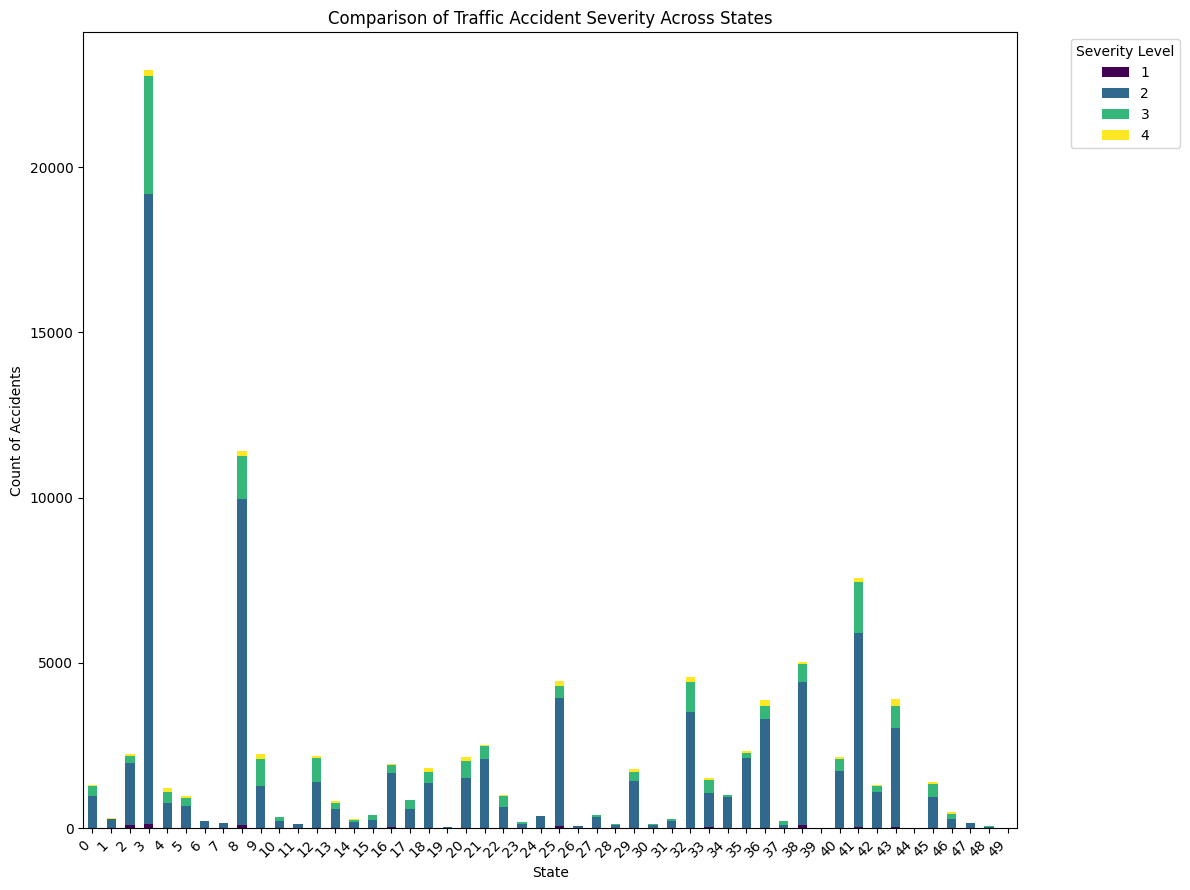

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

severity_counts = df.groupby(['State', 'Severity']).size().unstack()

severity_counts.plot(kind='bar', stacked=True, figsize=(12, 9), colormap='viridis')

plt.xlabel('State')
plt.ylabel('Count of Accidents')
plt.title('Comparison of Traffic Accident Severity Across States')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Severity Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Conclusion:**

The test returned a Chi-square statistic of chi2 with a p-value of p. Since the p-value is less than our threshold of 0.05, we reject the null hypothesis and conclude that there is a significant association between the state in which an accident occurs and the severity of that accident. This suggests that accident severity may vary by state.

# **5. Primary Analysis**

To answer the key questions, the machine learning technique used will be Random Forest Classifier using multi-class classification with Weather_Condtion, Hour_of_Day, and State as the input and Severity as the output.

Random Forest Classification will be able to handle non-linear and complex relationships between the three separate inputs. It will also provide feature importance information to answer the question of which feature is most important for determining and preventing traffic accidents.

**Prepare Data**

In [21]:
from sklearn.preprocessing import LabelEncoder

# Encode Weather_Condition and State
weather_encoder = LabelEncoder()
state_encoder = LabelEncoder()
df['Weather_Condition'] = weather_df['Weather_Condition']
df['Weather_Condition'] = weather_encoder.fit_transform(df['Weather_Condition'])
df['State'] = state_encoder.fit_transform(df['State'])

**Defining X and y**

In [22]:
X = df[['Weather_Condition', 'Hour_of_Day', 'State']]
y = df['Severity']

**Split Data**

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Train Model**

In [24]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

**Evaluate Model**

In [25]:
from sklearn.metrics import classification_report, log_loss

# Predict and evaluate
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Log loss
loss = log_loss(y_test, y_pred_proba)
print(f"Log Loss: {loss}")

              precision    recall  f1-score   support

           1       0.02      0.48      0.04       165
           2       0.85      0.41      0.55     16158
           3       0.23      0.36      0.28      3332
           4       0.06      0.34      0.10       555

    accuracy                           0.40     20210
   macro avg       0.29      0.40      0.24     20210
weighted avg       0.72      0.40      0.49     20210

Log Loss: 1.5355465023050743


# **6. Visualization**



**Confusion Matrix**

<Axes: >

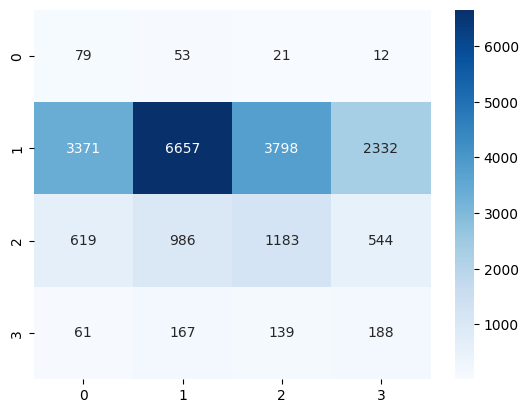

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

**Feature Importance**

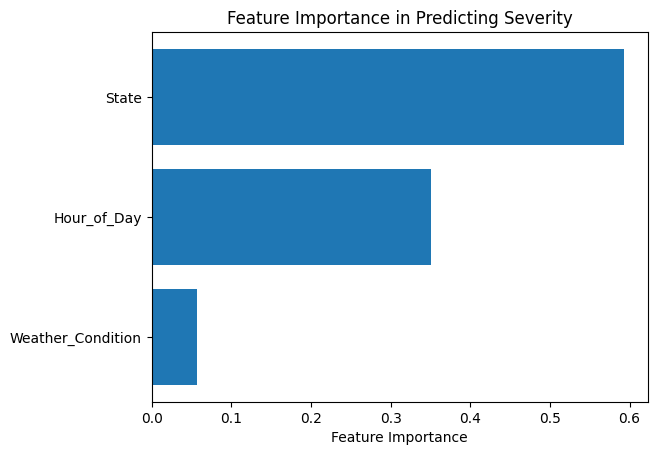

In [35]:
import matplotlib.pyplot as plt
import numpy as np

importance = clf.feature_importances_
feature_names = ['Weather_Condition', 'Hour_of_Day', 'State']
plt.barh(np.arange(len(importance)), importance, tick_label=feature_names)
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Predicting Severity")
plt.show()

**Probability Distributions**

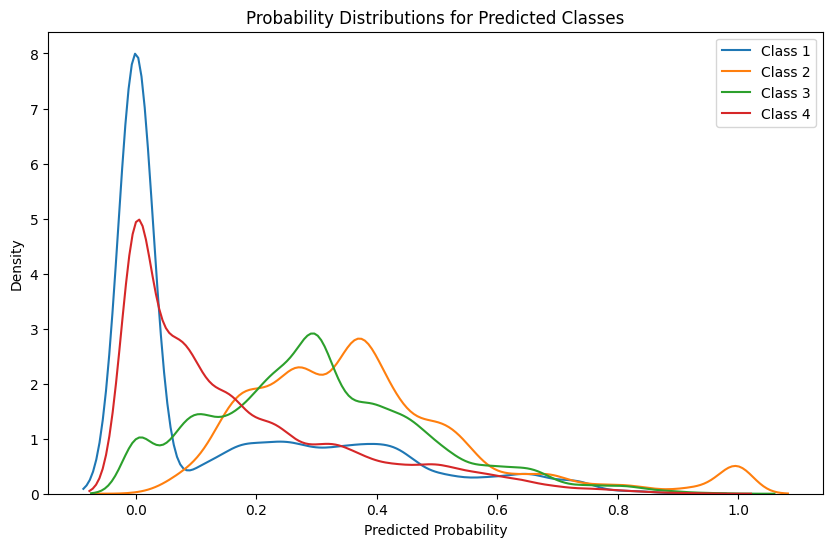

In [36]:
import seaborn as sns

plt.figure(figsize=(10, 6))
for i, class_label in enumerate(clf.classes_):
    sns.kdeplot(y_pred_proba[:, i], label=f"Class {class_label}")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Probability Distributions for Predicted Classes")
plt.legend()
plt.show()

# **7. Insights and Conclusions**

# Key Takeaways:

From our initial data exploration, we are able to see that accidents during the night are more severe than those during the day. Furthermore, improved lighting and nighttime driving regulations could reduce severity. Additionally, precipitation and low visibility significantly increase accident severity. Enhanced warning systems and road maintenance during adverse weather can mitigate this. Some states experience more severe accidents than others, likely due to differences in road conditions, enforcement, or weather. This highlights the need for localized safety measures.
In actuality, from the model that we created, using random forest classification, we can see from the feature importance that the most important factor in determining accident severity is the state that it occured in. From the data, we observed that California was the region with the highest density in accidents. The model is not as accurate as we would like it to be. This could be due to a multitude of factors. One of the factors that we have narrowed down is that the sampling of our data being uneven (densely populated data in specific regions). We could fix this by throwing out our state feature or focusing on one specific region in the United States at a time. Another fix would be to analyze the relationship between states and the other features to understand if region does have an impact on the other features and to account for any implications.
Our model may not has been as accurate as possible because the relationship between the features are too complex, and its difficult to pick one as the defining factor for accident severity as they could all be interconnected to contribute. We may need a neural network or a more complicated model in order to account for this interconnected complexity.

# Future Work:
In the future, we believe that analyzing other features, such as vehicle type or driver behavior, would be ideal for deeper insights. Furthermore, we would like to incorporate machine learning techniques to predict accident severity based on given conditions.

# Impact:
This analysis provides valuable insights for policymakers, urban planners, and transportation agencies to improve road safety and reduce traffic accident severity.

